In [286]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as sstat
from mpmath import mp
import math
import random

psd = pd.DataFrame
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

In [287]:
##VARIABILI:
mu0 = 120
sigma0 = 4
N = 1000
#mu = prior().sample()
mu_obs = 123
sigma_obs = 3
y_obs = tfp.distributions.Normal(mu_obs,sigma_obs).sample(1000)
s_obs =S(y_obs)
h=0.8

In [288]:
#likelihood vera
def lik_real(mu,n,y,sigma):
    med = 1/n*np.sum(y)
    yyy = []
   # ssum = np.sum(yyy)
    for j in range(len(y)):
        yyy.append((y[j]-med)**2)
        ssum = np.sum(yyy)
        res = math.e**(-1/(2*sigma**2)*(n*(mu-med)**2 + ssum))
    return res

In [289]:
def single_lik(mu):
   y= tfd.Normal(mu,sigma_obs)
   return y

In [290]:
def prior():
    return tfd.Normal(mu0,sigma0)
    

In [291]:
def real_posterior(mu0,n,y):
    y= tfd.Normal(1/(1/sigma0**2 + n/sigma_obs**2)*(mu0/sigma0**2 + (np.sum(y)/sigma_obs**2)),1/(1/sigma0**2 + n/sigma_obs**2))   #??? non sono molto sicura di averla scritta bene
    return y

(array([  6.,  40.,  76., 166., 198., 228., 170.,  73.,  37.,   6.]),
 array([122.89729712, 122.90263238, 122.90796763, 122.91330289,
        122.91863815, 122.9239734 , 122.92930866, 122.93464392,
        122.93997917, 122.94531443, 122.95064969]),
 <a list of 10 Patch objects>)

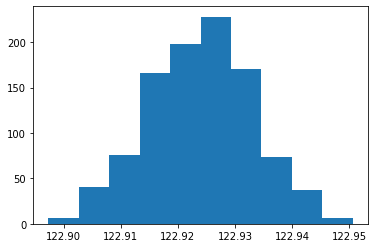

In [292]:
ciaoooo = real_posterior(mu0,1000,y_obs)
uuuu = ciaoooo.sample(1000)
plt.hist(uuuu)

In [293]:
def proposal(teta1):
  #return tfd.uniform(0,1).sample()
  return tfd.Normal(teta1,4)

In [294]:
def my_kernel(u):
  return 1/(np.sqrt(2*math.pi))*np.exp(-1/2*u**2)

In [295]:
def K_h(u):
  return my_kernel(u/h)/h

In [296]:
def S1(y):
  quantiles=[]
  for i in range(9):
      quantiles.append(np.quantile(y,0.1+0.1*i))
      #np.mean(y)
  return quantiles

In [297]:
def S(y):
  return np.mean(y)

in teoria non serve la target perché creiamo la distribuzione con la simulazione

In [298]:
def abc_algo (N, s_obs):
    theta=[]
    s = []
    y = []
    theta_0 = prior().sample()
    #theta.append(theta_0)
    y_0 = single_lik(theta_0).sample() 
    s_0 = S(y_0)
    #theta.append(teta_0)
    #s.append(s_0)
    #y.append(y_0)
    
    #IT=0
    while K_h(np.linalg.norm(np.array(s_0)-np.array(s_obs)))<=0:
        theta_0 = prior().sample()
        y_0 = single_lik(theta_0).sample() 
        s_0 = S(y_0)
       # IT= IT +1
    #print(IT)
    theta.append(theta_0)
    s.append(s_0)
    y.append(y_0)
    theta_old = theta_0
    s_old = s_0
    y_old = y_0

    for i in range(N):
        theta_current = proposal(theta_old).sample()
        y_current = single_lik(theta_current).sample()
        y.append(y_current)
        s_current = S(y)
               
        prob = min([1.,(K_h(np.linalg.norm(np.array(s_current) - np.array(s_obs)))*prior().prob(theta_current)*proposal(theta_old).prob(theta_current))/(
             K_h(np.linalg.norm(np.array(s_old)-np.array(s_obs)))*prior().prob(theta_old)*proposal(theta_current).prob(theta_old))])
        u = tfd.Uniform(0,1).sample()
        if u < prob:
              theta_i = theta_current
              s_i = s_current
        else: 
              theta_i = theta_old
              s_i = s_old
              y.pop()
              y.append(y_old)

        theta_old = theta_i
        s_old = s_i
        
        theta.append(theta_i)
        s.append(s_i)
        
    return  theta

In [299]:
prova = abc_algo (1000, s_obs)

(array([  1.,  11.,  67.,  83., 182., 284., 187., 139.,  36.,  11.]),
 array([106.13043 , 108.608826, 111.08723 , 113.56562 , 116.04402 ,
        118.522415, 121.00081 , 123.47921 , 125.9576  , 128.436   ,
        130.9144  ], dtype=float32),
 <a list of 10 Patch objects>)

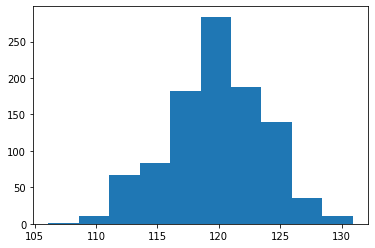

In [300]:
plt.hist(prova)
#x_grid= np.linspace(1.,20.,1000)
#mu = prior(mu0)
#y_obs = tfp.distributions.Normal(mu,5).sample(1000)
#n = len(y_obs)
#y = target(mu, n, y_obs).sample(1000)  # sample?
#print(y)
#plt.plot(x_grid , y)
#print(prova)

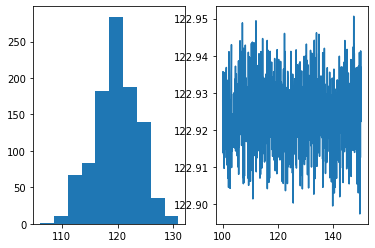

In [301]:
x_grid= np.linspace(100,150,1000)
f,axs = plt.subplots(1,2)
axs[0].hist(prova)
axs[1].plot(x_grid , uuuu)

# qualcosa non va in questa y...

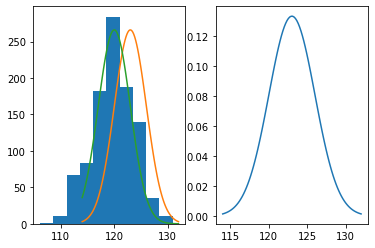

In [302]:
import scipy.stats as stats
x = np.linspace(mu_obs - 3*sigma_obs, mu_obs + 3*sigma_obs, 100)
f,axs = plt.subplots(1,2)
axs[0].hist(prova)
#axs[0].plot(123, np.linspace(0,250,250))
axs[0].plot(x, 2000*stats.norm.pdf(x, mu_obs, sigma_obs))
axs[0].plot(x, 2000*stats.norm.pdf(x, mu0, sigma_obs))
axs[1].plot(x, stats.norm.pdf(x, mu_obs, sigma_obs))
plt.show()